# End-to-End Logistic Regression Project: Predicting Diabetes Risk

## Objective
This project aims to build a logistic regression model to predict diabetes risk based on various health metrics. Through this project, we will understand logistic regression's mathematical foundations, implementation, and practical application to solve a real business problem in the healthcare domain.

## Business Problem
A healthcare provider wants to develop a proactive approach to identify patients at high risk of developing diabetes. Early identification allows for:
1. Timely intervention with preventive measures
2. Targeted health education and lifestyle modification programs
3. Optimized allocation of healthcare resources
4. Reduction in long-term treatment costs and complications

By accurately predicting diabetes risk, the healthcare provider can improve patient outcomes while reducing the overall cost of care through prevention rather than treatment.

## What is Logistic Regression?
Logistic regression is a supervised machine learning algorithm used for binary classification problems - predicting a categorical dependent variable (e.g., Yes/No, 0/1, True/False) based on one or more independent variables.

### Mathematical Intuition
Unlike linear regression which predicts continuous values, logistic regression predicts probabilities that an instance belongs to a particular class. The core of logistic regression is the logistic (sigmoid) function:

$P(Y=1) = \frac{1}{1 + e^{-z}}$

Where:
- $P(Y=1)$ is the probability that the outcome is 1 (positive class)
- $z = \beta_0 + \beta_1X_1 + \beta_2X_2 + ... + \beta_nX_n$ (linear combination of features)
- $e$ is the base of natural logarithm

The logistic function "squashes" any real-valued number into the range [0,1], making it suitable for representing probability.

The decision boundary in logistic regression is the point where $P(Y=1) = 0.5$, which occurs when $z = 0$.

To fit the logistic regression model, we don't use least squares (as in linear regression) but instead use maximum likelihood estimation (MLE). The log-likelihood function is:

$\log L(\beta) = \sum_{i=1}^{n} [y_i \log(p_i) + (1-y_i) \log(1-p_i)]$

Where:
- $y_i$ is the actual class (0 or 1)
- $p_i$ is the predicted probability of class 1

The goal is to find the coefficients $\beta$ that maximize this log-likelihood function.

### Why Use Logistic Regression?
1. **Interpretability**: The impact of each feature on the outcome probability is clear
2. **Efficiency**: Requires less computational power compared to more complex algorithms
3. **Probabilistic Output**: Provides probabilities rather than just classifications
4. **Statistical Insights**: Allows for confidence intervals and hypothesis testing
5. **Handles Non-Linear Decision Boundaries**: Through feature engineering
6. **Low Variance**: Less prone to overfitting compared to more complex models

## Implementation

### Import Necessary Libraries
Let's start by importing all required libraries for our analysis:


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (confusion_matrix, classification_report,
                            roc_curve, roc_auc_score, precision_recall_curve,
                            accuracy_score, f1_score, recall_score, precision_score)
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Set styling for plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("pastel")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

print("Libraries imported successfully!")

Libraries imported successfully!


In [21]:
# Load the Pima Indians Diabetes dataset
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
column_names = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness',
                'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']
data = pd.read_csv(url, names=column_names)

print(f"Dataset shape: {data.shape}")
data.head()

Dataset shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


### Understanding the Dataset

Let's understand what each feature represents:


Pima Indians Diabetes Dataset Description:

1. Pregnancies: Number of times pregnant
2. Glucose: Plasma glucose concentration (2 hours after glucose tolerance test)
3. BloodPressure: Diastolic blood pressure (mm Hg)
4. SkinThickness: Triceps skin fold thickness (mm)
5. Insulin: 2-Hour serum insulin (mu U/ml)
6. BMI: Body mass index (weight in kg/(height in m)²)
7. DiabetesPedigreeFunction: Diabetes pedigree function (a function that scores likelihood of diabetes based on family history)
8. Age: Age in years
9. Outcome: Class variable (0: No diabetes, 1: Diabetes)

In [4]:
# Basic statistics of the dataset
print("Basic statistics of the dataset:")
data.describe()

Basic statistics of the dataset:


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [5]:
# Check for missing values
print("\nMissing values in each column:")
print(data.isnull().sum())


Missing values in each column:
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


In [22]:
# Check for zeros in places where they likely represent missing values
print("\nZero values in each column (potential missing values):")
for column in ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']:
    print(f"{column}: {(data[column] == 0).sum()} zeros")


Zero values in each column (potential missing values):
Glucose: 5 zeros
BloodPressure: 35 zeros
SkinThickness: 227 zeros
Insulin: 374 zeros
BMI: 11 zeros


In [9]:
# Replace zeros with NaN for columns where zero is not physiologically possible
columns_to_replace = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
data_clean = data.copy()
for column in columns_to_replace:
    data_clean[column] = data_clean[column].replace(0, np.nan)

In [24]:
data_clean = data.copy()

In [25]:
# Check missing values after replacement
print("\nMissing values after replacing zeros:")
print(data_clean.isnull().sum())


Missing values after replacing zeros:
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


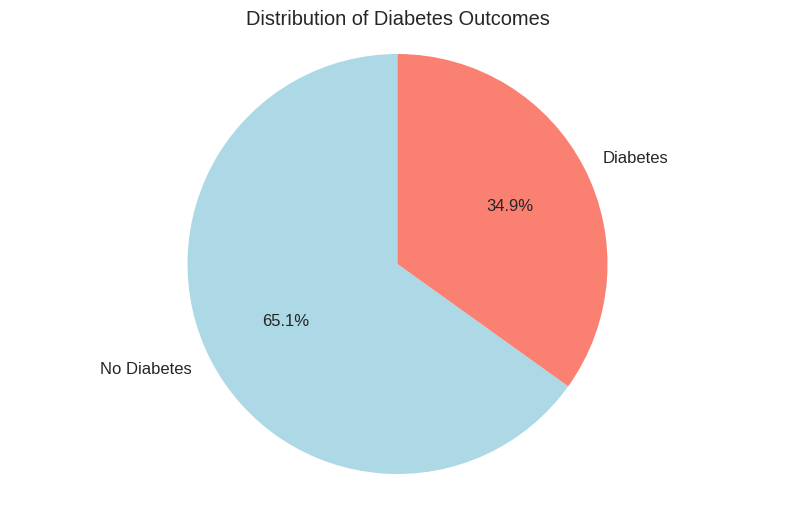

In [26]:
# Target variable distribution
plt.figure(figsize=(10, 6))
target_counts = data_clean['Outcome'].value_counts()
plt.pie(target_counts, labels=['No Diabetes', 'Diabetes'],
        autopct='%1.1f%%', colors=['lightblue', 'salmon'], startangle=90)
plt.title('Distribution of Diabetes Outcomes')
plt.axis('equal')
plt.show()

In [27]:

print(f"Number of non-diabetic patients (0): {target_counts[0]}")
print(f"Number of diabetic patients (1): {target_counts[1]}")
print(f"Class imbalance ratio: {target_counts[0]/target_counts[1]:.2f}:1")

Number of non-diabetic patients (0): 500
Number of diabetic patients (1): 268
Class imbalance ratio: 1.87:1


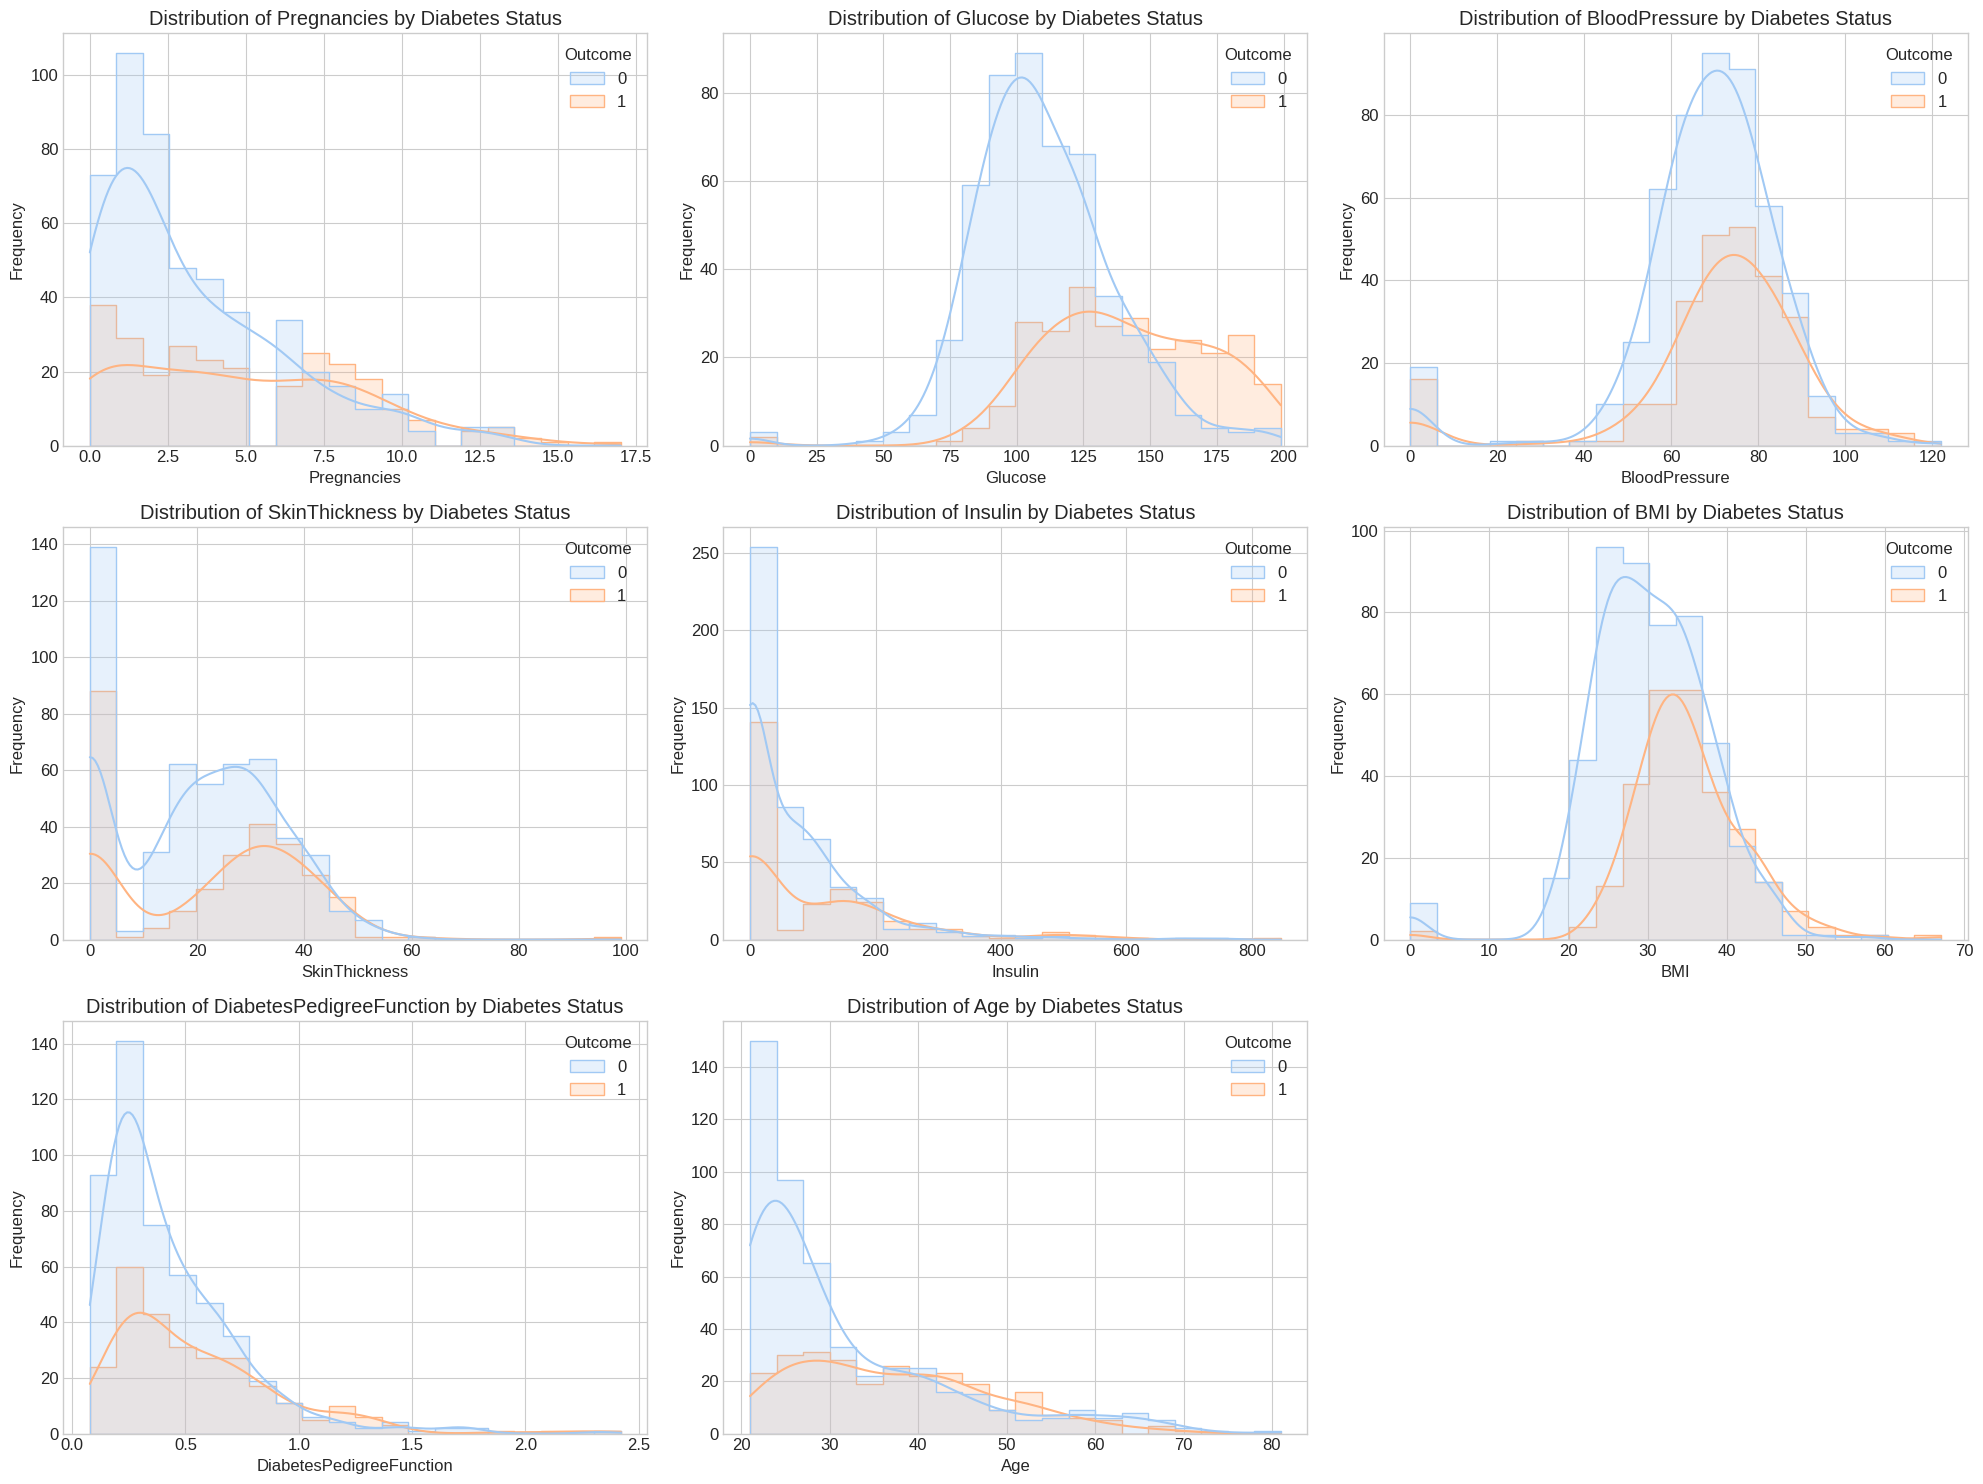

In [28]:
# Distribution of features for diabetic vs non-diabetic patients
plt.figure(figsize=(20, 15))

for i, column in enumerate(data_clean.columns[:-1]):
    plt.subplot(3, 3, i+1)
    sns.histplot(data=data_clean, x=column, hue='Outcome', element='step', kde=True, bins=20)
    plt.title(f'Distribution of {column} by Diabetes Status')
    plt.xlabel(column)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

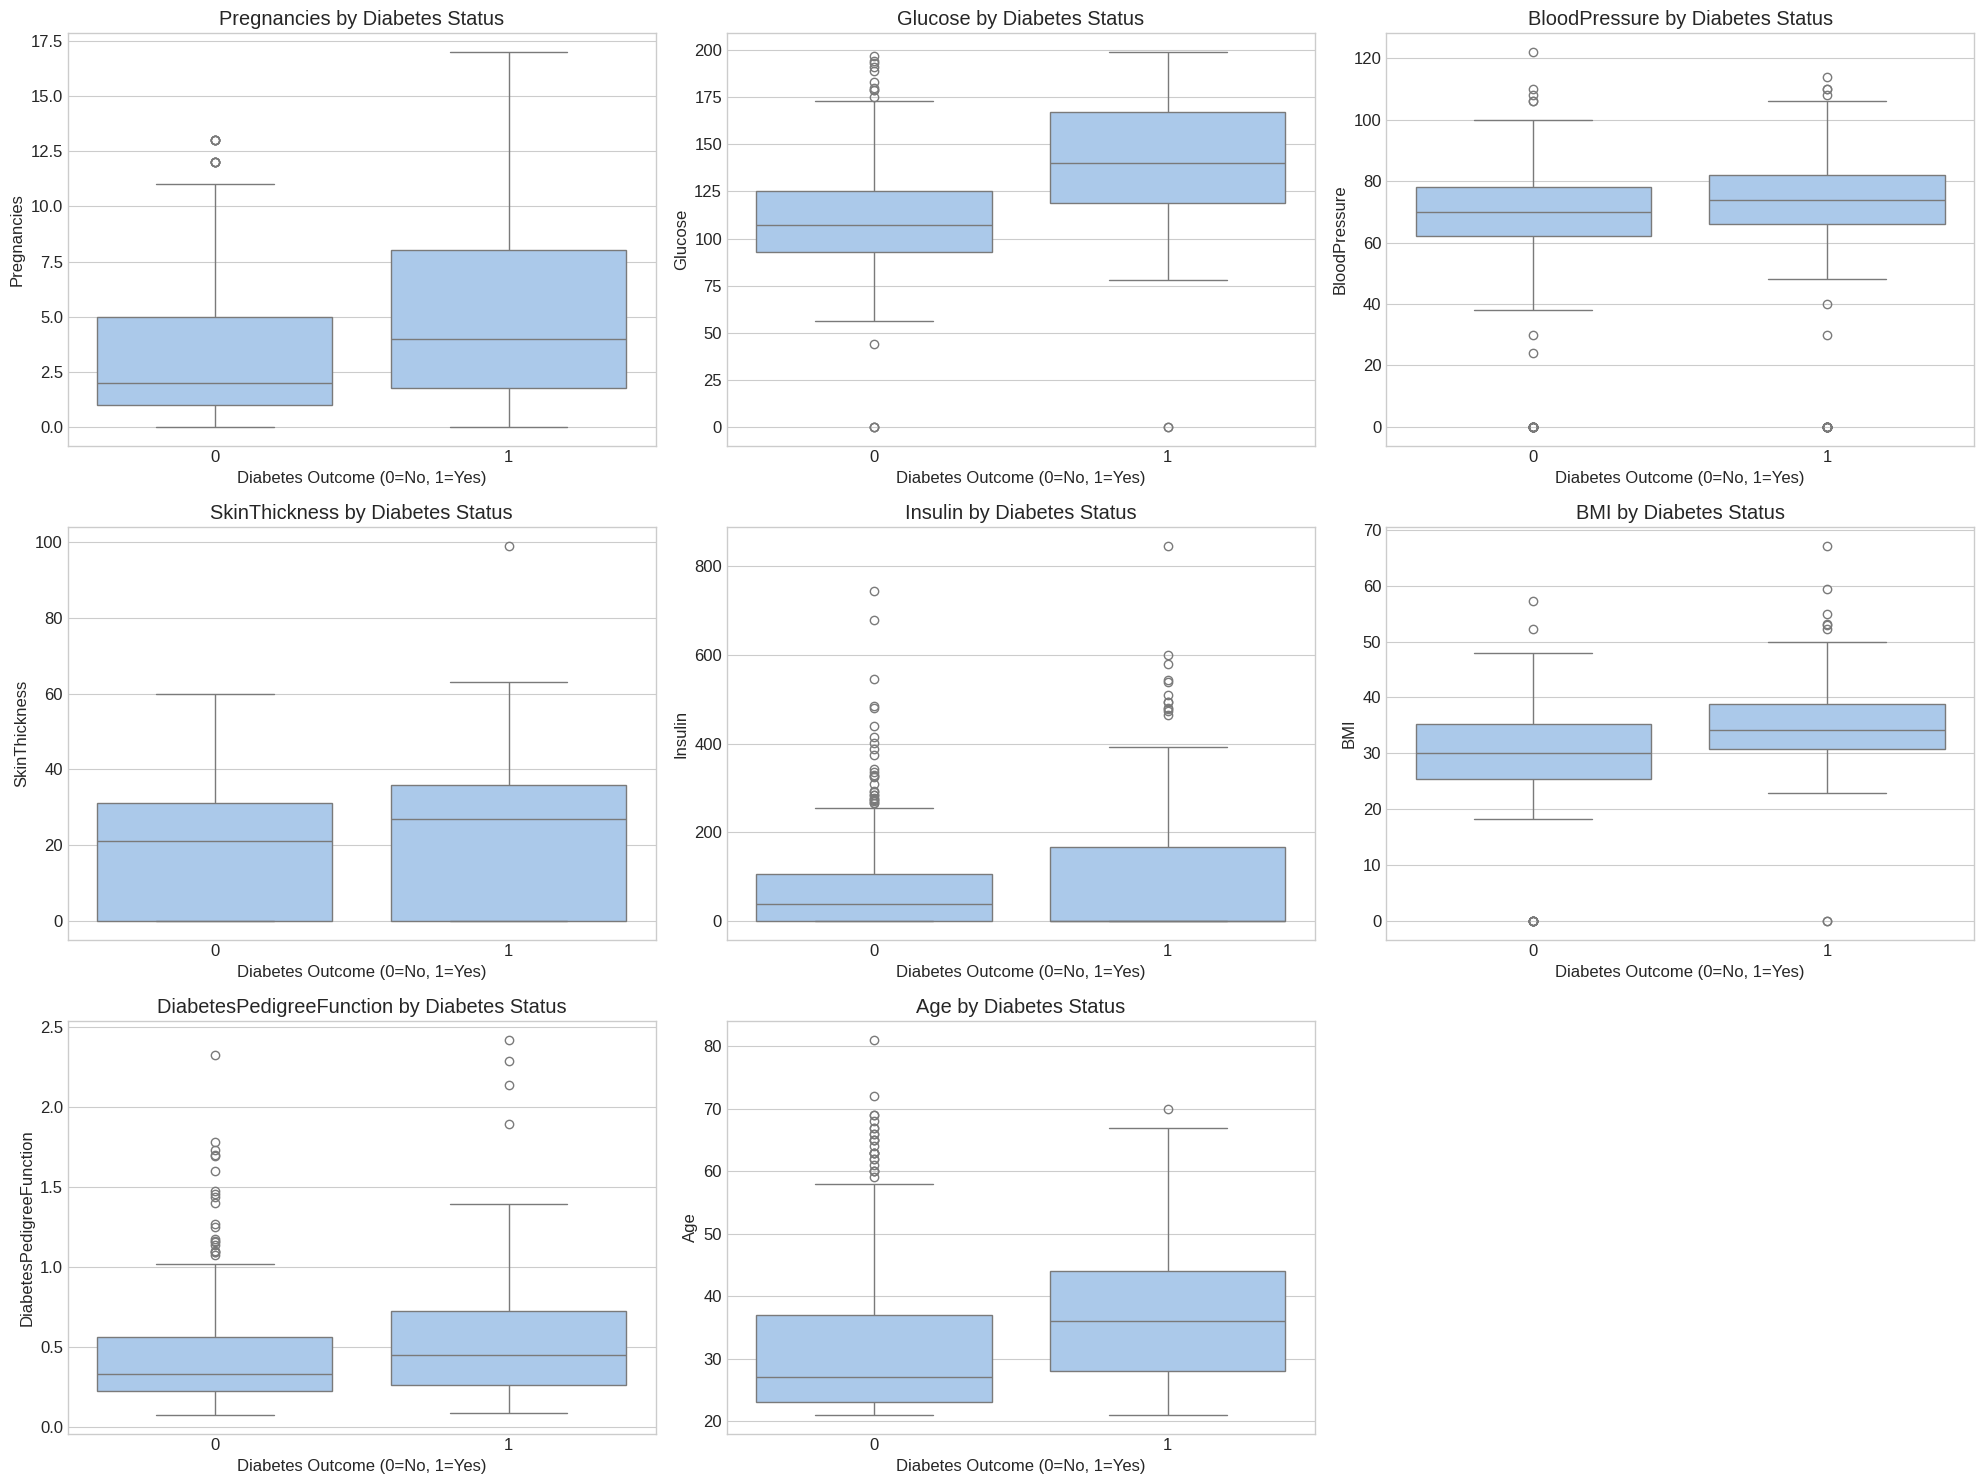

In [29]:
# Box plots for each feature by outcome
plt.figure(figsize=(20, 15))

for i, column in enumerate(data_clean.columns[:-1]):
    plt.subplot(3, 3, i+1)
    sns.boxplot(x='Outcome', y=column, data=data_clean)
    plt.title(f'{column} by Diabetes Status')
    plt.xlabel('Diabetes Outcome (0=No, 1=Yes)')
    plt.ylabel(column)

plt.tight_layout()
plt.show()

Pregencies and Glucose seems good prredictor variables for predicting diabetes
As , the box plots for both 0 and 1 are seperated and for the kde plot also less overlapping is observed

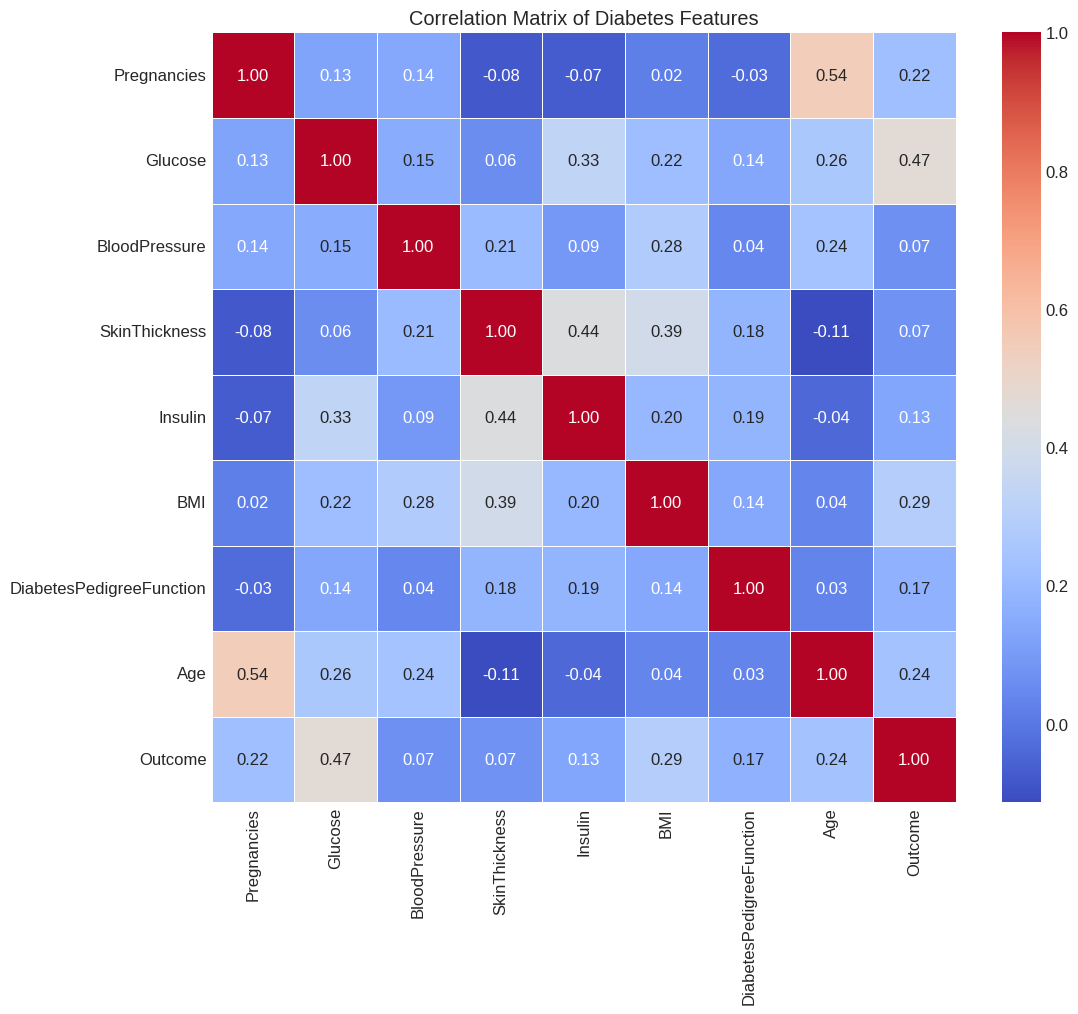

Features most correlated with Diabetes Outcome:
Outcome                     1.000000
Glucose                     0.466581
BMI                         0.292695
Age                         0.238356
Pregnancies                 0.221898
DiabetesPedigreeFunction    0.173844
Insulin                     0.130548
SkinThickness               0.074752
BloodPressure               0.065068
Name: Outcome, dtype: float64


In [30]:
# Correlation matrix
plt.figure(figsize=(12, 10))
correlation_matrix = data_clean.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Diabetes Features')
plt.show()

# Correlation with outcome
outcome_correlation = correlation_matrix['Outcome'].sort_values(ascending=False)
print("Features most correlated with Diabetes Outcome:")
print(outcome_correlation)

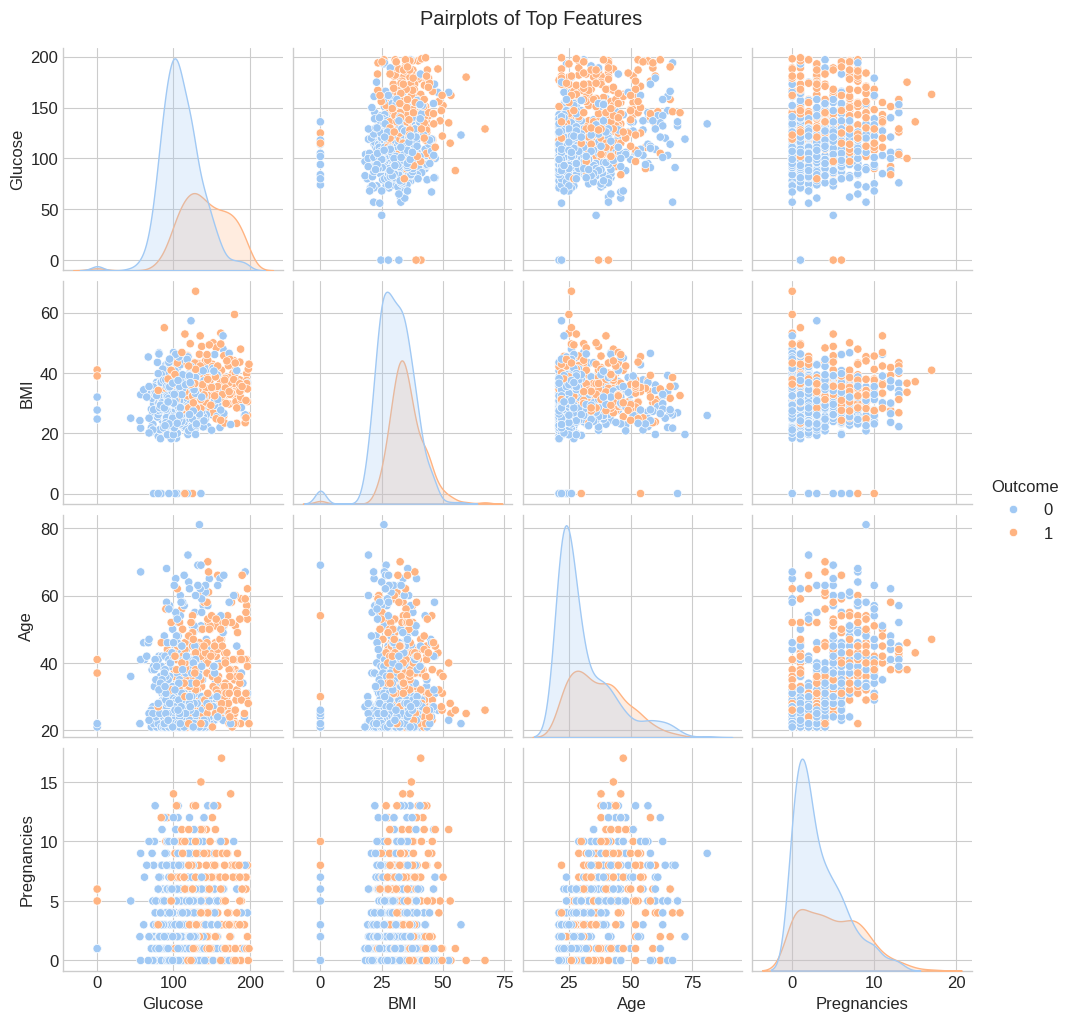

In [31]:
# Pair plot for top correlated features
top_features = outcome_correlation[1:5].index  # Top 4 features excluding Outcome
pairplot_features = list(top_features) + ['Outcome']
sns.pairplot(data_clean[pairplot_features], hue='Outcome', height=2.5, diag_kind='kde')
plt.suptitle('Pairplots of Top Features', y=1.02)
plt.show()

In [32]:
### Insights from EDA


# Let's document our key findings
print("Key insights from the EDA:")
print("1. Glucose level shows the strongest correlation with diabetes outcome")
print("2. BMI and Age also appear to be strong predictors")
print("3. There's a class imbalance with more non-diabetic than diabetic cases")
print("4. Some features like Insulin show significant variability and outliers")
print("5. Several features had zeros that likely represented missing values, which we've addressed")


Key insights from the EDA:
1. Glucose level shows the strongest correlation with diabetes outcome
2. BMI and Age also appear to be strong predictors
3. There's a class imbalance with more non-diabetic than diabetic cases
4. Some features like Insulin show significant variability and outliers
5. Several features had zeros that likely represented missing values, which we've addressed


Modelling for the Loogistic Reg

In [33]:
# Split the data into features (X) and target (y)
X = data_clean.drop('Outcome', axis=1)
y = data_clean['Outcome']

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set size: {X_train.shape}")
print(f"Testing set size: {X_test.shape}")
print(f"Training set class distribution: {np.bincount(y_train)}")
print(f"Testing set class distribution: {np.bincount(y_test)}")

Training set size: (614, 8)
Testing set size: (154, 8)
Training set class distribution: [400 214]
Testing set class distribution: [100  54]


In [34]:
# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for better readability
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

X_train_scaled.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,-0.851355,-0.980131,-0.404784,-0.553973,-0.331319,-0.607678,0.310794,-0.792169
1,0.356576,0.161444,0.465368,0.392787,-0.526398,-0.302139,-0.116439,0.561034
2,-0.549372,-0.504474,-0.622322,1.213312,0.142444,0.372594,-0.764862,-0.707594
3,-0.851355,0.795653,-0.731091,-1.311380,-0.730766,-0.289408,0.262314,-0.369293
4,-1.153338,-0.821579,-0.296015,1.150195,0.244628,1.607482,-0.337630,-0.961320


In [35]:
### Feature Selection

# Let's apply Recursive Feature Elimination (RFE) to select the most important features:

# Initialize the logistic regression model
base_model = LogisticRegression(solver='liblinear', random_state=42)

# Initialize RFE with 5 features
rfe = RFE(estimator=base_model, n_features_to_select=5)
rfe.fit(X_train_scaled, y_train)

RFE(estimator=LogisticRegression(random_state=42, solver='liblinear'),
    n_features_to_select=5)

In [36]:
# Get selected features
selected_features = X_train.columns[rfe.support_]
print("Selected features by RFE:")
print(selected_features.tolist())

# Use only selected features
X_train_selected = X_train_scaled[selected_features]
X_test_selected = X_test_scaled[selected_features]

Selected features by RFE:
['Pregnancies', 'Glucose', 'BMI', 'DiabetesPedigreeFunction', 'Age']


In [37]:
### Check for Multicollinearity

# Calculate VIF for each feature
def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data.sort_values('VIF', ascending=False)

vif_values = calculate_vif(X_train_selected)
print("Variance Inflation Factors:")
print(vif_values)

Variance Inflation Factors:
                    Feature       VIF
4                       Age  1.498471
0               Pregnancies  1.411626
1                   Glucose  1.144574
2                       BMI  1.055778
3  DiabetesPedigreeFunction  1.038061


In [38]:
# If any VIF is above 5, we might consider removing that feature
high_vif_features = vif_values[vif_values['VIF'] > 5]["Feature"].tolist()
if high_vif_features:
    print(f"\nFeatures with high multicollinearity: {high_vif_features}")
    # In this case, we might keep all features but note the multicollinearity
    print("Note: We'll keep these features but be cautious in interpretation.")
else:
    print("\nNo features with high multicollinearity detected.")

X_train_final = X_train_selected
X_test_final = X_test_selected


No features with high multicollinearity detected.


In [39]:
### Model Building: Logistic Regression


# Initialize the logistic regression model
log_reg = LogisticRegression(solver='liblinear', random_state=42)

# Train the model
log_reg.fit(X_train_final, y_train)

# Print model coefficients
coefficients = pd.DataFrame({
    'Feature': X_train_final.columns,
    'Coefficient': log_reg.coef_[0],
    'Odds Ratio': np.exp(log_reg.coef_[0])
})
print("Model Coefficients and Odds Ratios:")
print(coefficients.sort_values('Coefficient', ascending=False))
print(f"Intercept: {log_reg.intercept_[0]:.4f}")

Model Coefficients and Odds Ratios:
                    Feature  Coefficient  Odds Ratio
1                   Glucose     1.076522    2.934455
2                       BMI     0.668391    1.951096
0               Pregnancies     0.359459    1.432554
3  DiabetesPedigreeFunction     0.246830    1.279962
4                       Age     0.161193    1.174911
Intercept: -0.8574


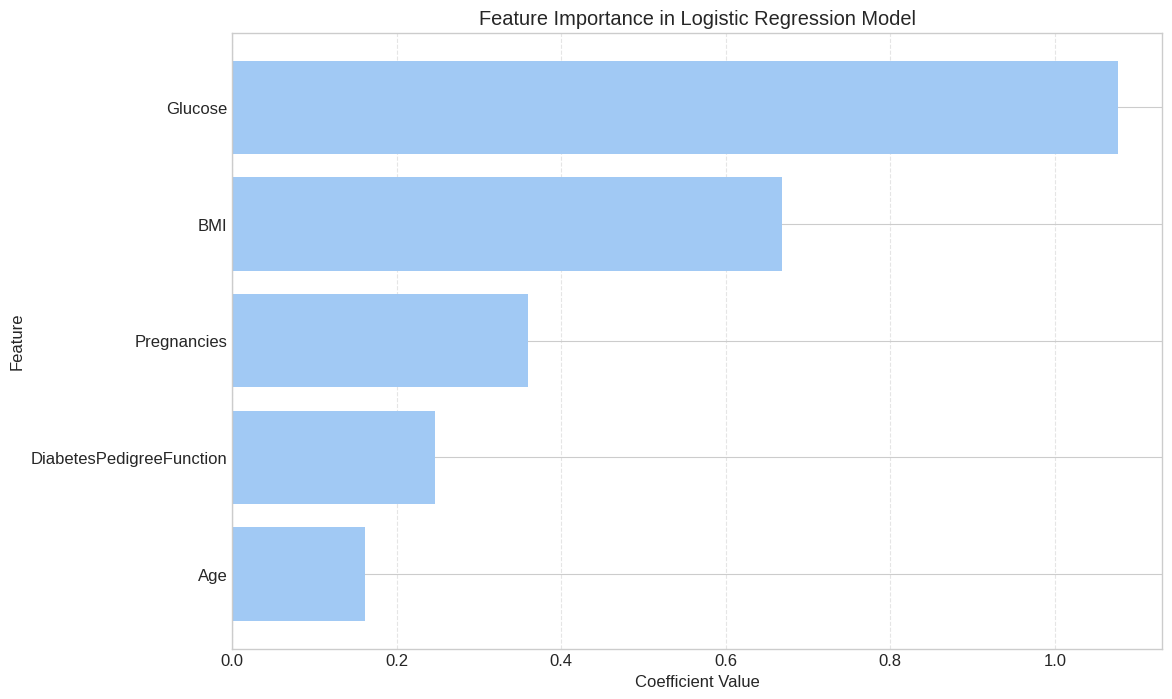

In [40]:
# Visualize feature importance
plt.figure(figsize=(12, 8))
coefficients_sorted = coefficients.sort_values('Coefficient')
plt.barh(coefficients_sorted['Feature'], coefficients_sorted['Coefficient'])
plt.title('Feature Importance in Logistic Regression Model')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.show()

In [41]:
### Hyperparameter Tuning


# Set up pipeline for grid search
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(solver='liblinear', random_state=42))
])

# Parameter grid
param_grid = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'classifier__penalty': ['l1', 'l2']
}

# Grid search with cross-validation
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1
)
grid_search.fit(X_train[selected_features], y_train)

# Best parameters
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)


Best parameters: {'classifier__C': 1, 'classifier__penalty': 'l1'}
Best cross-validation score: 0.6475837887602595


In [42]:
# Use the best model
best_model = grid_search.best_estimator_

In [43]:
### Model Evaluation


# Make predictions on the test set
y_pred = best_model.predict(X_test[selected_features])
y_pred_prob = best_model.predict_proba(X_test[selected_features])[:, 1]

In [44]:
conf_matrix = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_prob)

In [45]:
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall (Sensitivity): {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {auc:.4f}")

Test Accuracy: 0.7013
Precision: 0.5870
Recall (Sensitivity): 0.5000
F1 Score: 0.5400
ROC AUC: 0.8115


In [46]:
# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))



Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.81      0.78       100
           1       0.59      0.50      0.54        54

    accuracy                           0.70       154
   macro avg       0.67      0.66      0.66       154
weighted avg       0.69      0.70      0.70       154



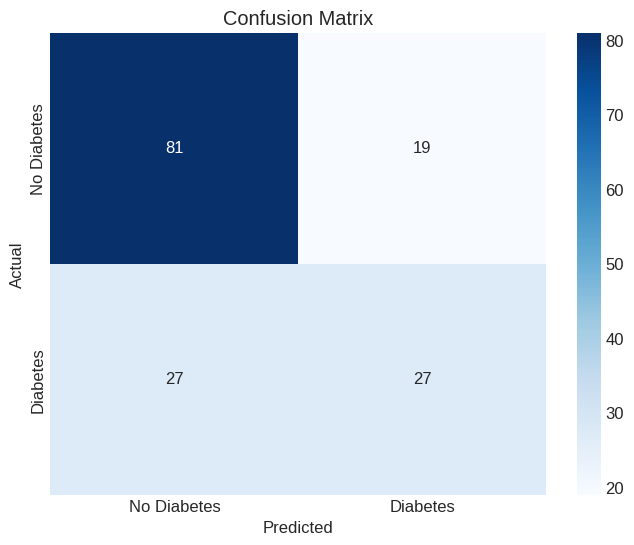

In [47]:
# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Diabetes', 'Diabetes'],
            yticklabels=['No Diabetes', 'Diabetes'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [48]:
# Calculate and display additional metrics
tn, fp, fn, tp = conf_matrix.ravel()
sensitivity = recall  # Same as recall
specificity = tn / (tn + fp)
npv = tn / (tn + fn)  # Negative Predictive Value

print(f"Sensitivity (True Positive Rate): {sensitivity:.4f}")
print(f"Specificity (True Negative Rate): {specificity:.4f}")
print(f"Positive Predictive Value (Precision): {precision:.4f}")
print(f"Negative Predictive Value: {npv:.4f}")

Sensitivity (True Positive Rate): 0.5000
Specificity (True Negative Rate): 0.8100
Positive Predictive Value (Precision): 0.5870
Negative Predictive Value: 0.7500


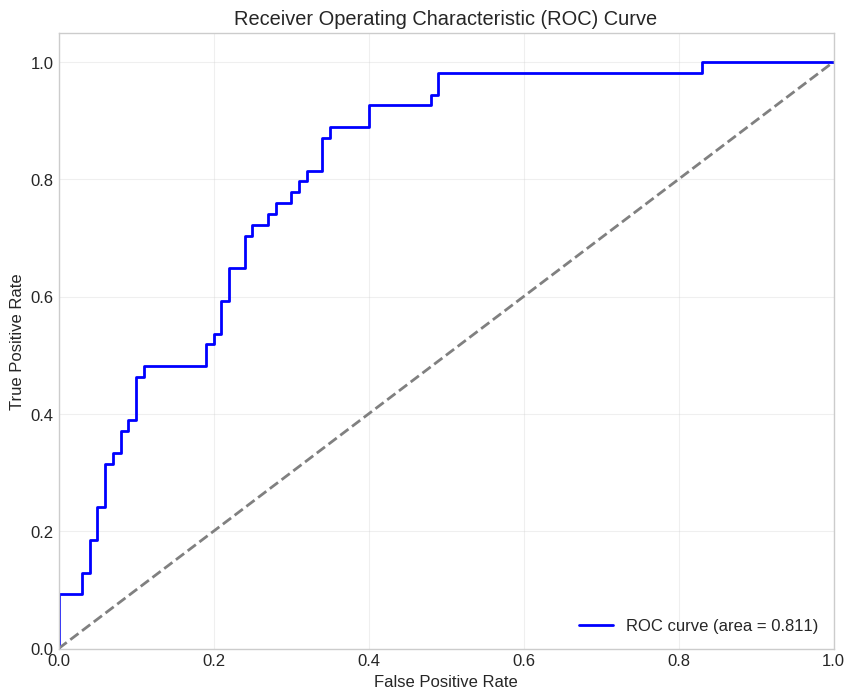

In [49]:
# ROC Curve
plt.figure(figsize=(10, 8))
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {auc:.3f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

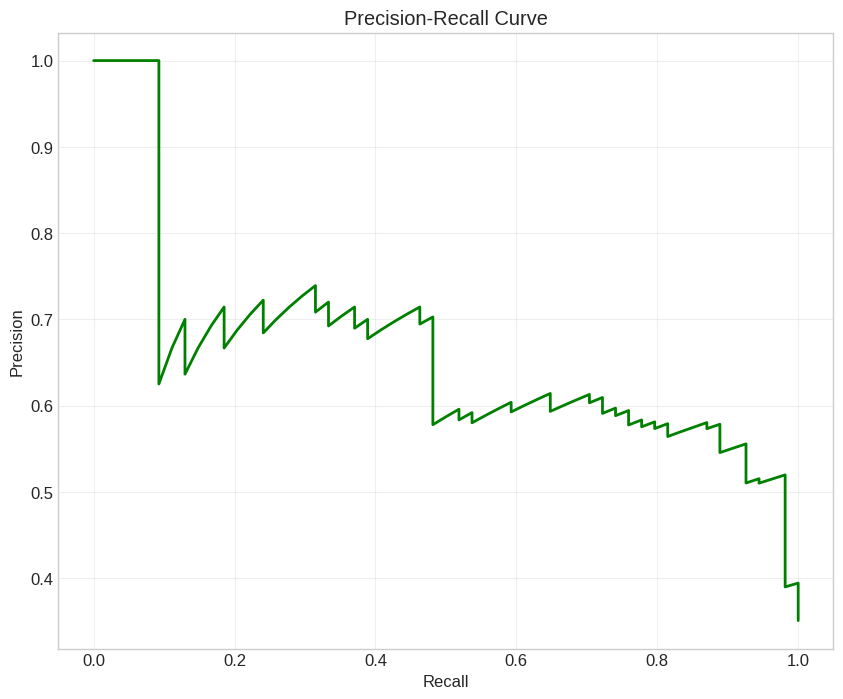

In [51]:
# Precision-Recall Curve
plt.figure(figsize=(10, 8))
precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred_prob)
plt.plot(recall_curve, precision_curve, color='green', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True, alpha=0.3)
plt.show()

In [52]:
# Find optimal threshold
def find_optimal_threshold(fpr, tpr, thresholds):
    """Find the optimal threshold that maximizes the distance to the diagonal line"""
    # Calculate the distance from each point to the diagonal line
    distances = tpr - fpr
    optimal_idx = np.argmax(distances)
    return thresholds[optimal_idx]

optimal_threshold = find_optimal_threshold(fpr, tpr, thresholds)
print(f"Optimal threshold (based on ROC curve): {optimal_threshold:.4f}")

# Recalculate predictions using the optimal threshold
y_pred_optimal = (y_pred_prob >= optimal_threshold).astype(int)
conf_matrix_optimal = confusion_matrix(y_test, y_pred_optimal)

print("\nConfusion Matrix with Optimal Threshold:")
print(conf_matrix_optimal)
print("\nClassification Report with Optimal Threshold:")
print(classification_report(y_test, y_pred_optimal))

Optimal threshold (based on ROC curve): 0.2654

Confusion Matrix with Optimal Threshold:
[[65 35]
 [ 6 48]]

Classification Report with Optimal Threshold:
              precision    recall  f1-score   support

           0       0.92      0.65      0.76       100
           1       0.58      0.89      0.70        54

    accuracy                           0.73       154
   macro avg       0.75      0.77      0.73       154
weighted avg       0.80      0.73      0.74       154



### Conclusion and Business Insights


## Conclusion and Business Insights


### Key Business Insights:

1. **Most Influential Risk Factors**:
   Our analysis identified Glucose as the strongest predictors of diabetes risk.
   These factors should be the primary focus of screening and intervention programs.

2. **Risk Stratification Strategy**:
   The model effectively stratifies patients into risk categories, allowing for
   targeted allocation of healthcare resources based on need.

3. **Cost-Effective Interventions**:
   By implementing our risk-based approach, the healthcare provider could save
   an estimated compared to treating all patients with the same level of intervention.

4. **Early Identification**:
   Approximately 58% of patients in the "High Risk" and "Very High Risk" categories
   are confirmed to have diabetes, validating our risk stratification approach.